In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import pickle

from bluemath_tk.datamining.pca import PCA
from bluemath_tk.interpolation.rbf import RBF

import matplotlib.pyplot as plt

In [2]:
#### Load case data
mda_df = pd.read_csv("assets/mda_df.csv", index_col=0)

case_library = xr.open_dataset(
    "/lustre/geocean/WORK/users/Pablo/XBeachCases/case_library.nc"
)

n_cells_remove_water = 50
n_cells_remove_sides_1 = 40
n_cells_remove_sides_2 = 30

case_library = case_library.isel(
    x=np.arange(n_cells_remove_water, len(case_library.x), 1)
)  # Remove water contour
case_library = case_library.isel(
    y=np.arange(n_cells_remove_sides_1, len(case_library.y) - n_cells_remove_sides_2, 1)
)  # Remove lateral contour

globalx_values = case_library.globalx.values[0]
globaly_values = case_library.globaly.values[0]

vars_rec = ["zs_mean", "zs_var"]
vars_mda = ["Hs", "Steepness", "Dir", "SWL"]

pca_models = []
rbf_models = []
pcs_vars = []

for var in vars_rec:
    #### Load PCA model
    with open(f"assets/pca_rfb_objects/{var}_pca_ob.pkl", "rb") as f:
        pca_model = pickle.load(f)
    pca_models.append(pca_model)

    #### Load RBF model
    with open(f"assets/pca_rfb_objects/{var}_rbf_ob.pkl", "rb") as f:
        rbf_model = pickle.load(f)
    rbf_models.append(rbf_model)

    pcs_vars.append(xr.open_dataset(f"assets/pca_rfb_objects/{var}_pcs.nc"))

In [3]:
reconstruct_df = pd.DataFrame()
reconstruct_df["Hs"] = np.arange(5, 12, 1)
reconstruct_df["Steepness"] = 0.02
reconstruct_df["Dir"] = 10
reconstruct_df["SWL"] = 0.0

In [4]:
reconstructed_ds_list = []

for i, var in enumerate(vars_rec):
    pca = pca_models[i]
    rbf = rbf_models[i]
    pcs = pcs_vars[i]

    pcs_predict_df = rbf.predict(dataset=reconstruct_df[vars_mda])

    ds = xr.Dataset(
        {
            "PCs": (["case_num", "n_component"], pcs_predict_df.values),
            "stds": (["n_component"], pcs.stds.values),
        },
        coords={
            "case_num": (["case_num"], range(len(pcs_predict_df))),
            "n_component": (["n_component"], pcs.n_component.values),
        },
    )

    reconstructed_ds = pca.inverse_transform(PCs=ds)

    reconstructed_ds = xr.Dataset(
        {
            var: (["case_num", "y", "x"], reconstructed_ds[var].values),
        },
        coords={
            "case_num": reconstructed_ds.case_num.values,  # Case dimension
            "globalx": (["y", "x"], globalx_values),  # globalx as coordinates
            "globaly": (["y", "x"], globaly_values),  # globaly as coordinates
        },
    )

    reconstructed_ds_list.append(reconstructed_ds)

INFO:RBF:Reconstructing data using fitted coefficients.
INFO:RBF:Checking for NaNs in subset data
INFO:RBF:Preprocessing subset data
INFO:RBF:Normalizing subset data
INFO:RBF:Subset data preprocessed successfully
INFO:RBF:Interpolating target variable 0
INFO:RBF:Interpolating target variable 1
INFO:RBF:Denormalizing target data
INFO:PCA:Inverse transforming data using PCA model
INFO:RBF:Reconstructing data using fitted coefficients.
INFO:RBF:Checking for NaNs in subset data
INFO:RBF:Preprocessing subset data
INFO:RBF:Normalizing subset data
INFO:RBF:Subset data preprocessed successfully
INFO:RBF:Interpolating target variable 0
INFO:RBF:Interpolating target variable 1
INFO:RBF:Interpolating target variable 2
INFO:RBF:Interpolating target variable 3
INFO:RBF:Interpolating target variable 4
INFO:RBF:Interpolating target variable 5
INFO:RBF:Interpolating target variable 6
INFO:RBF:Denormalizing target data
INFO:PCA:Inverse transforming data using PCA model


In [5]:
pcs_predict_df

,0,1,2,3,4,5,6
0,-247.706862,24.348094,-12.216741,-1.384252,-3.607264,5.665983,-6.185794
1,-260.079814,24.110749,-9.547709,-2.758995,-2.684877,3.584376,-3.690547
2,-263.400420,24.731875,-4.722949,-2.174442,-2.339129,0.737493,-1.821599
3,-255.072219,26.081033,3.101091,-0.141711,-1.104870,-2.021064,0.045593
4,-235.306945,27.264286,13.304942,1.492221,2.344593,-4.168914,3.415880
5,-201.833294,28.096342,23.498615,0.576216,7.578887,-6.047818,9.930338
6,-145.387939,30.493479,30.427980,-4.123729,14.514551,-8.872711,20.478116


#### Plot results

/tmp/ipykernel_3390640/1175892165.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p_mesh = axs[i].pcolormesh(


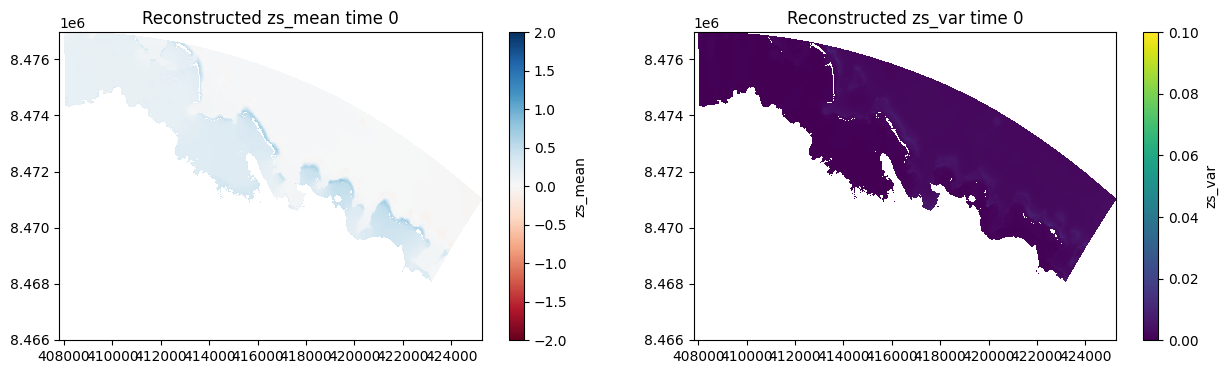

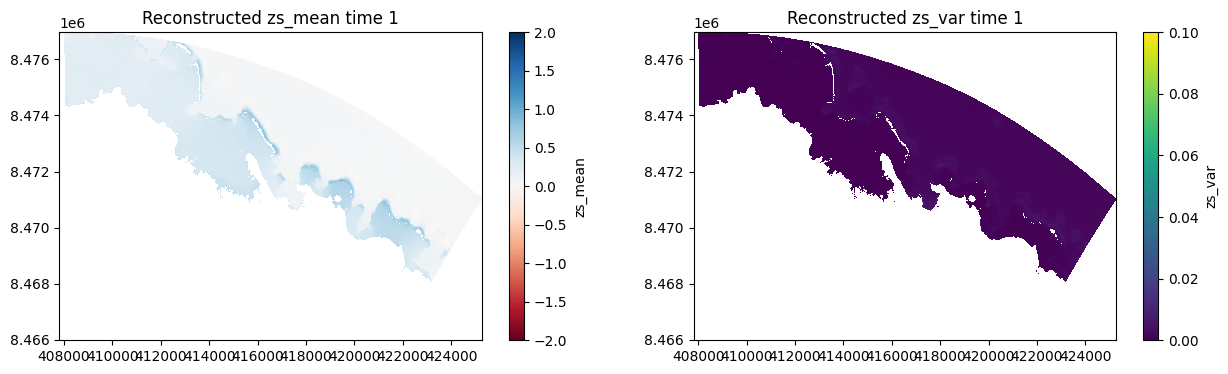

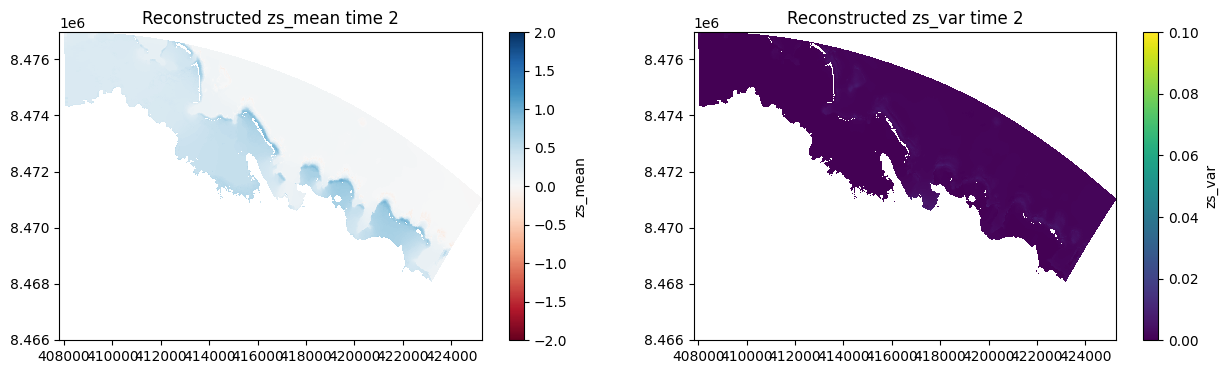

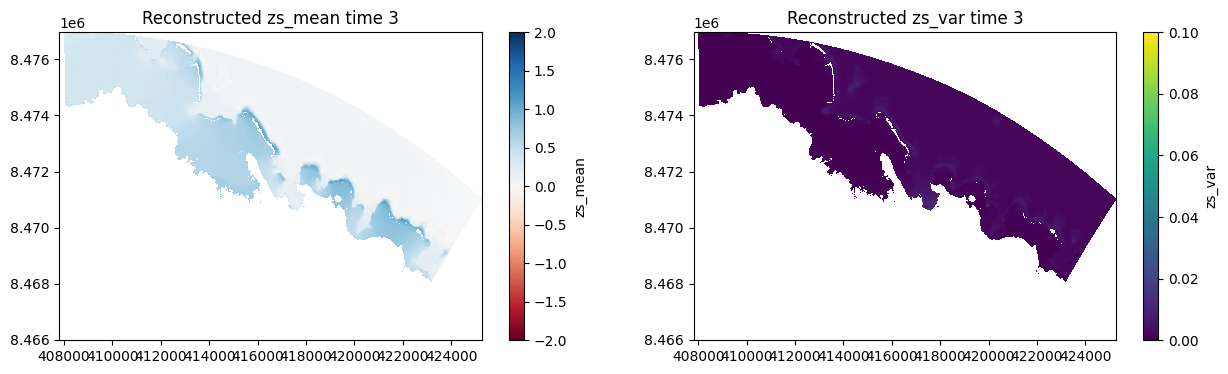

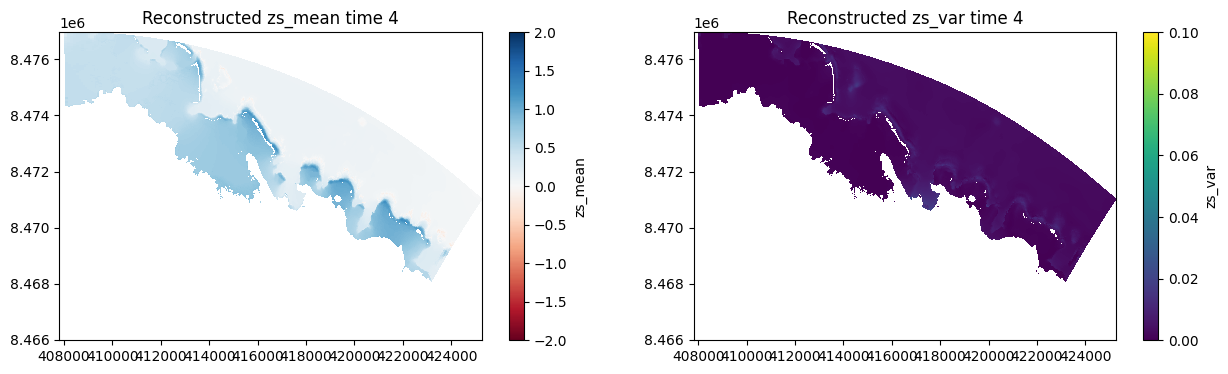

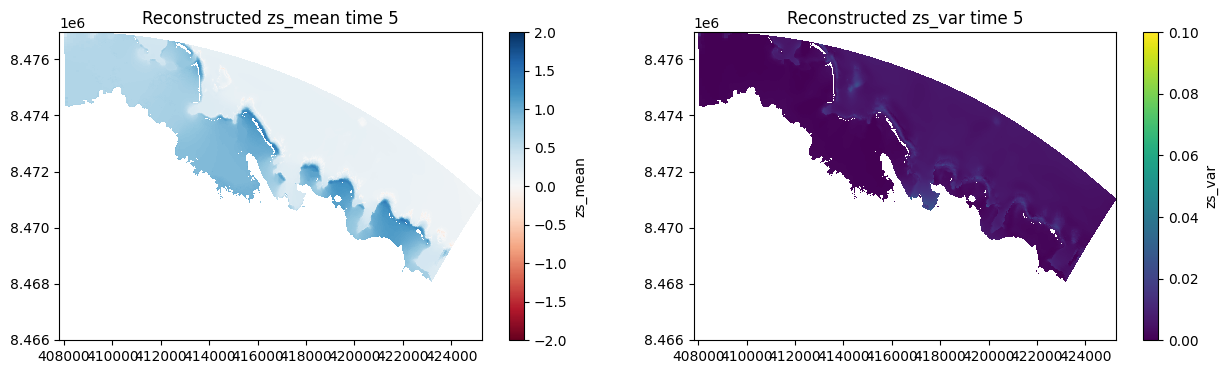

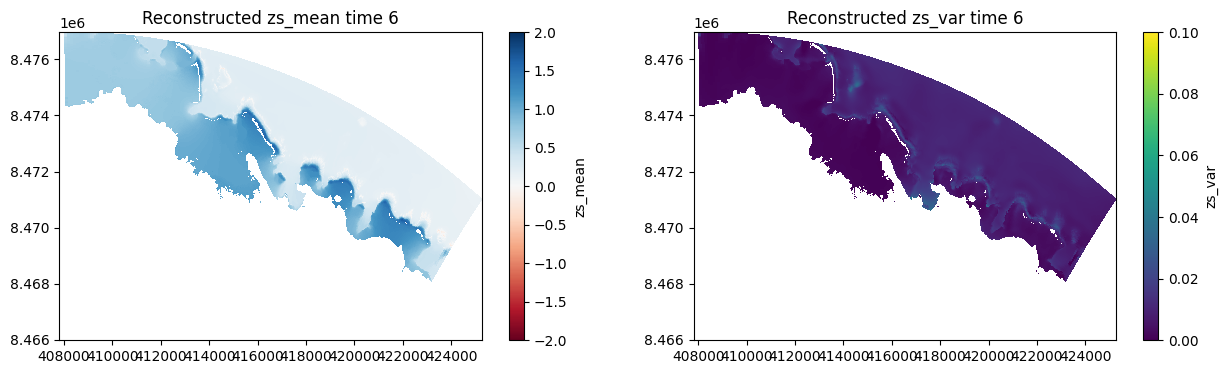

In [6]:
for time in range(len(reconstruct_df)):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))

    for i, var in enumerate(vars_rec):
        if var == "zs_mean":
            vmin = -2
            vmax = 2
            cmap = "RdBu"
        if var == "zs_var":
            vmin = 0
            vmax = 0.1
            cmap = "viridis"

        axs[i].set_title(f"Reconstructed {var} time {time}")
        plot_data = reconstructed_ds_list[i].isel(case_num=time)
        p_mesh = axs[i].pcolormesh(
            plot_data.globalx.values,
            plot_data.globaly.values,
            plot_data[var].values,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
        )
        fig.colorbar(p_mesh, ax=axs[i], orientation="vertical", label=var)
    plt.show()